# 0.0 IMPORTS

In [40]:
import pandas as pd
import inflection
import math
import numpy as np

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML
from IPython.display import Image

## 0.1. Helper functions

In [2]:
# setting seaborn style
sns.set_style("darkgrid")
sns.set_palette("Accent")

# setting matplolit inline
%matplotlib inline

## 0.2 Loading dada

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
199835,251,1,2015-02-02,25589,2847,1,1,0,0,a,c,340.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTION

In [5]:
# make a copy from original DataFrame, so we can separate the dataset manipulation by section
df1 = df_raw.copy()

## 1.1. Rename columns
Rename columns to make easier to understand and work with them.

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# snake_case
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [8]:
# verifying the operations
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2.  Data dimensions
Verify the number of rows and columns in the dataset.

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3.  Data types
Verifying the dataset data types.

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
# transforming 'date' column to datetime type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4.  Check NaN
Verifying presence of missing values.

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

We noticed that we have a lot of missing data. We can one of the following three paths:

**1) Exclude all lines that have missing data**, but we may lose important information that the ML algorithm may need and negatively impact the forecasting.

**2) Use ML techniques to fill in the missing data** and predict what value would be replace `NaN`. This method is good when we don't have business information available.

**3) Really understand the business.** Understand the business rules and fill in the missing data with relevant information.

## 1.5.  Fillout NA
We chose the method 3 (understand the business).

Let's take a look at data field descriptions from Kaggle.

https://www.kaggle.com/c/rossmann-store-sales/data

**Data fields**

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [13]:
# observing the maximum distance to the nearest competitor
df1['competition_distance'].max()

75860.0

In [14]:
# competition_distance
# let's assume that the distance from competitors is so long that there are no competitors
# applying for each column record: competition_distance
#     assign 200000.0 if record == NaN ; assign its current value if record != NaN
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# let's assume that the opening date is the store date: date
# axis=1 -> apply in the row along the columns, because we have more than one column in the expression
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [15]:
# promo_interval

# creating dictionary that will help in mapping
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# fill in the NaN with zeroes
df1['promo_interval'].fillna(0, inplace=True)

# creating the 'month_map' column as the month mapping of the 'date' column
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [16]:
df1.sample(5).T

,397752,976093,49639,321553,267075
store,663,139,580,105,931
day_of_week,6,3,3,3,6
date,2014-07-12 00:00:00,2013-02-06 00:00:00,2015-06-17 00:00:00,2014-10-01 00:00:00,2014-11-29 00:00:00
sales,4303,7716,9739,5558,2601
customers,645,582,1456,708,265
open,1,1,1,1,1
promo,0,1,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,a,a


In [17]:
# make a split in 'promo_interval' column and creates a list containing the values
# check if the value of 'month_map' is within that list
# creates column 'is_promo' with numeric values (1 = was in promo or 0 = was not in promo) based on the verification
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [18]:
df1.sample(5).T

,707046,574583,709648,885017,620211
store,922,29,179,493,1057
day_of_week,7,6,4,1,1
date,2013-10-06 00:00:00,2014-02-01 00:00:00,2013-10-03 00:00:00,2013-04-29 00:00:00,2013-12-23 00:00:00
sales,0,7251,0,10418,12457
customers,0,648,0,929,1269
open,0,1,0,1,1
promo,0,0,0,1,0
state_holiday,0,0,a,0,0
school_holiday,0,0,0,0,1
store_type,d,d,a,d,d


In [19]:
# verificando operações
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6.  Change types

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

We notice that the following columns are `float64`:
- `competition_open_since_month`
- `competition_open_since_year`
- `promo2_since_week` 
- `promo2_since_year` 

However, they are actually `int` values as the represent months and years which are discrete values. Thus, we can do:

In [21]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [22]:
# checking the operations
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

It is through the descriptive statistics that we get a notion from the business. 

It helps detect some errors

Two big metrics: distribution and central tendency

Central tendency: summary statistics, median, mean

We need to know how the data is distributed around the median and mean.

Skew and kurtosis.

Check how vars behave. Negative values that shouldn't

In [23]:
# creating a dataset for numerical attributes
num_attributes = df1.select_dtypes(include=['int64','float64'])

# creating a dataset for categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

In [24]:
# checking the operation
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
412139,375,5,9003,743,1,0,0,15710.0,2,2013,1,37,2009,0
419124,670,6,5404,609,1,0,0,2060.0,6,2014,1,45,2009,0


In [25]:
# checking the operation
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
805116,0,a,c,"Mar,Jun,Sept,Dec",Jul
934383,0,a,c,0,Mar


### 1.7.1 Numerical attributes

In [26]:
# central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# distribution: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [27]:
# checking the operations
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### Plotting distribution for `sales`

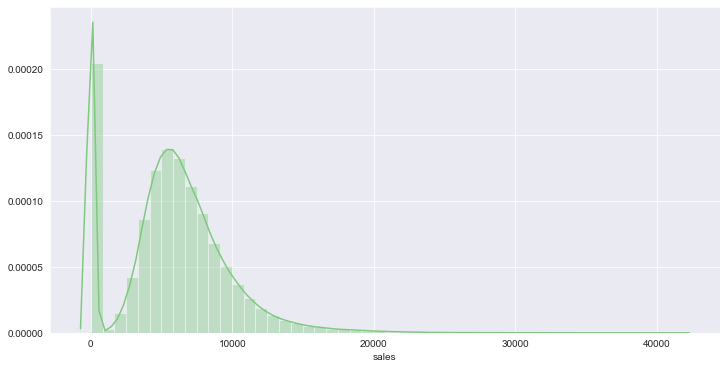

In [35]:
ax = sns.distplot(df1['sales'])

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

# display plot
plt.show()

#### Plotting distribution for `competition_distance`

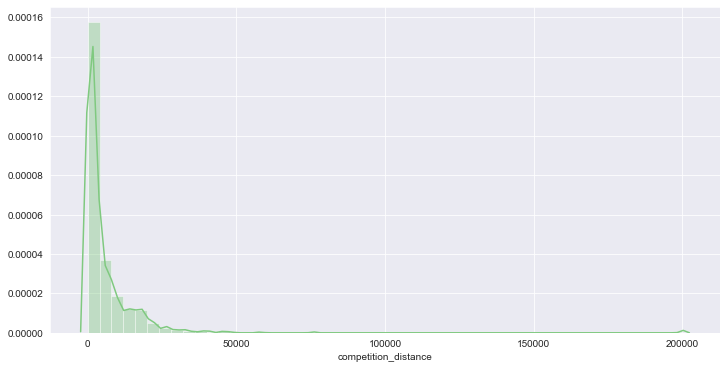

In [29]:
ax = sns.distplot(df1['competition_distance'])

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

# display plot
plt.show()

#### Using pandas.describe

In [34]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


### 1.7.1 Categorical attributes

In [30]:
# check how many types we have for each atribute
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

#### Plotting boxplots for `state_holiday`, `store_type` and `assortment` in relation to `sales`

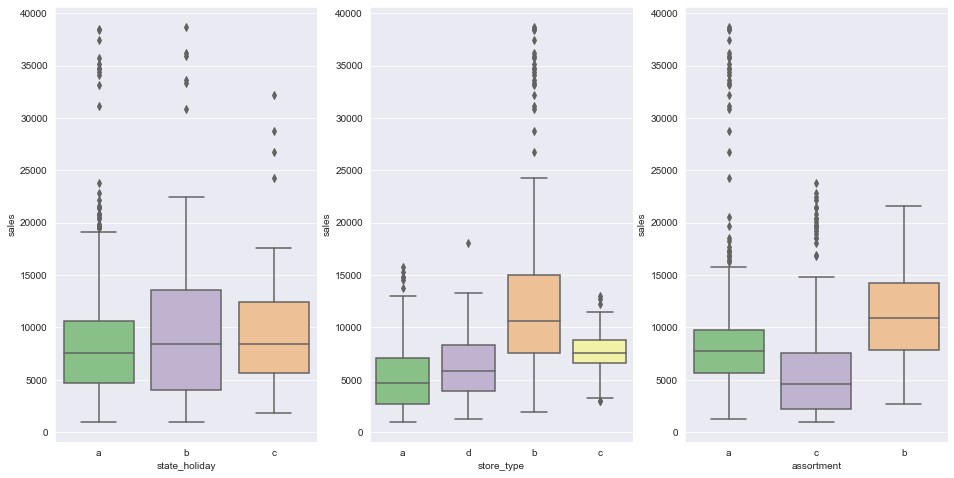

In [31]:
# filtering the data that we want to display
# as we don't want to see all the days on which the stores were closed
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# using the variable ax for single a Axes
fig, ax = plt.subplots()

# setting the figure size in inches
ax.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 1)
ax = sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
ax = sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
ax = sns.boxplot(x='assortment', y='sales', data=aux1)

# display plot
plt.show()

# 2.0 STEP 02 - FEATURE ENGINEERING

### 2.0.1 Project Checkpoint

Let's save our progress and make a checkpoint in our project by making a copy of `df1`. So we don't have to run everything from the start. We can start from here.

In [36]:
# copying df1 to df2
df2 = df1.copy()

## 2.1 Hypothesis Mindmap
In real life, we draw the mindmap with the stakeholders in a brainstorm-like meeting.

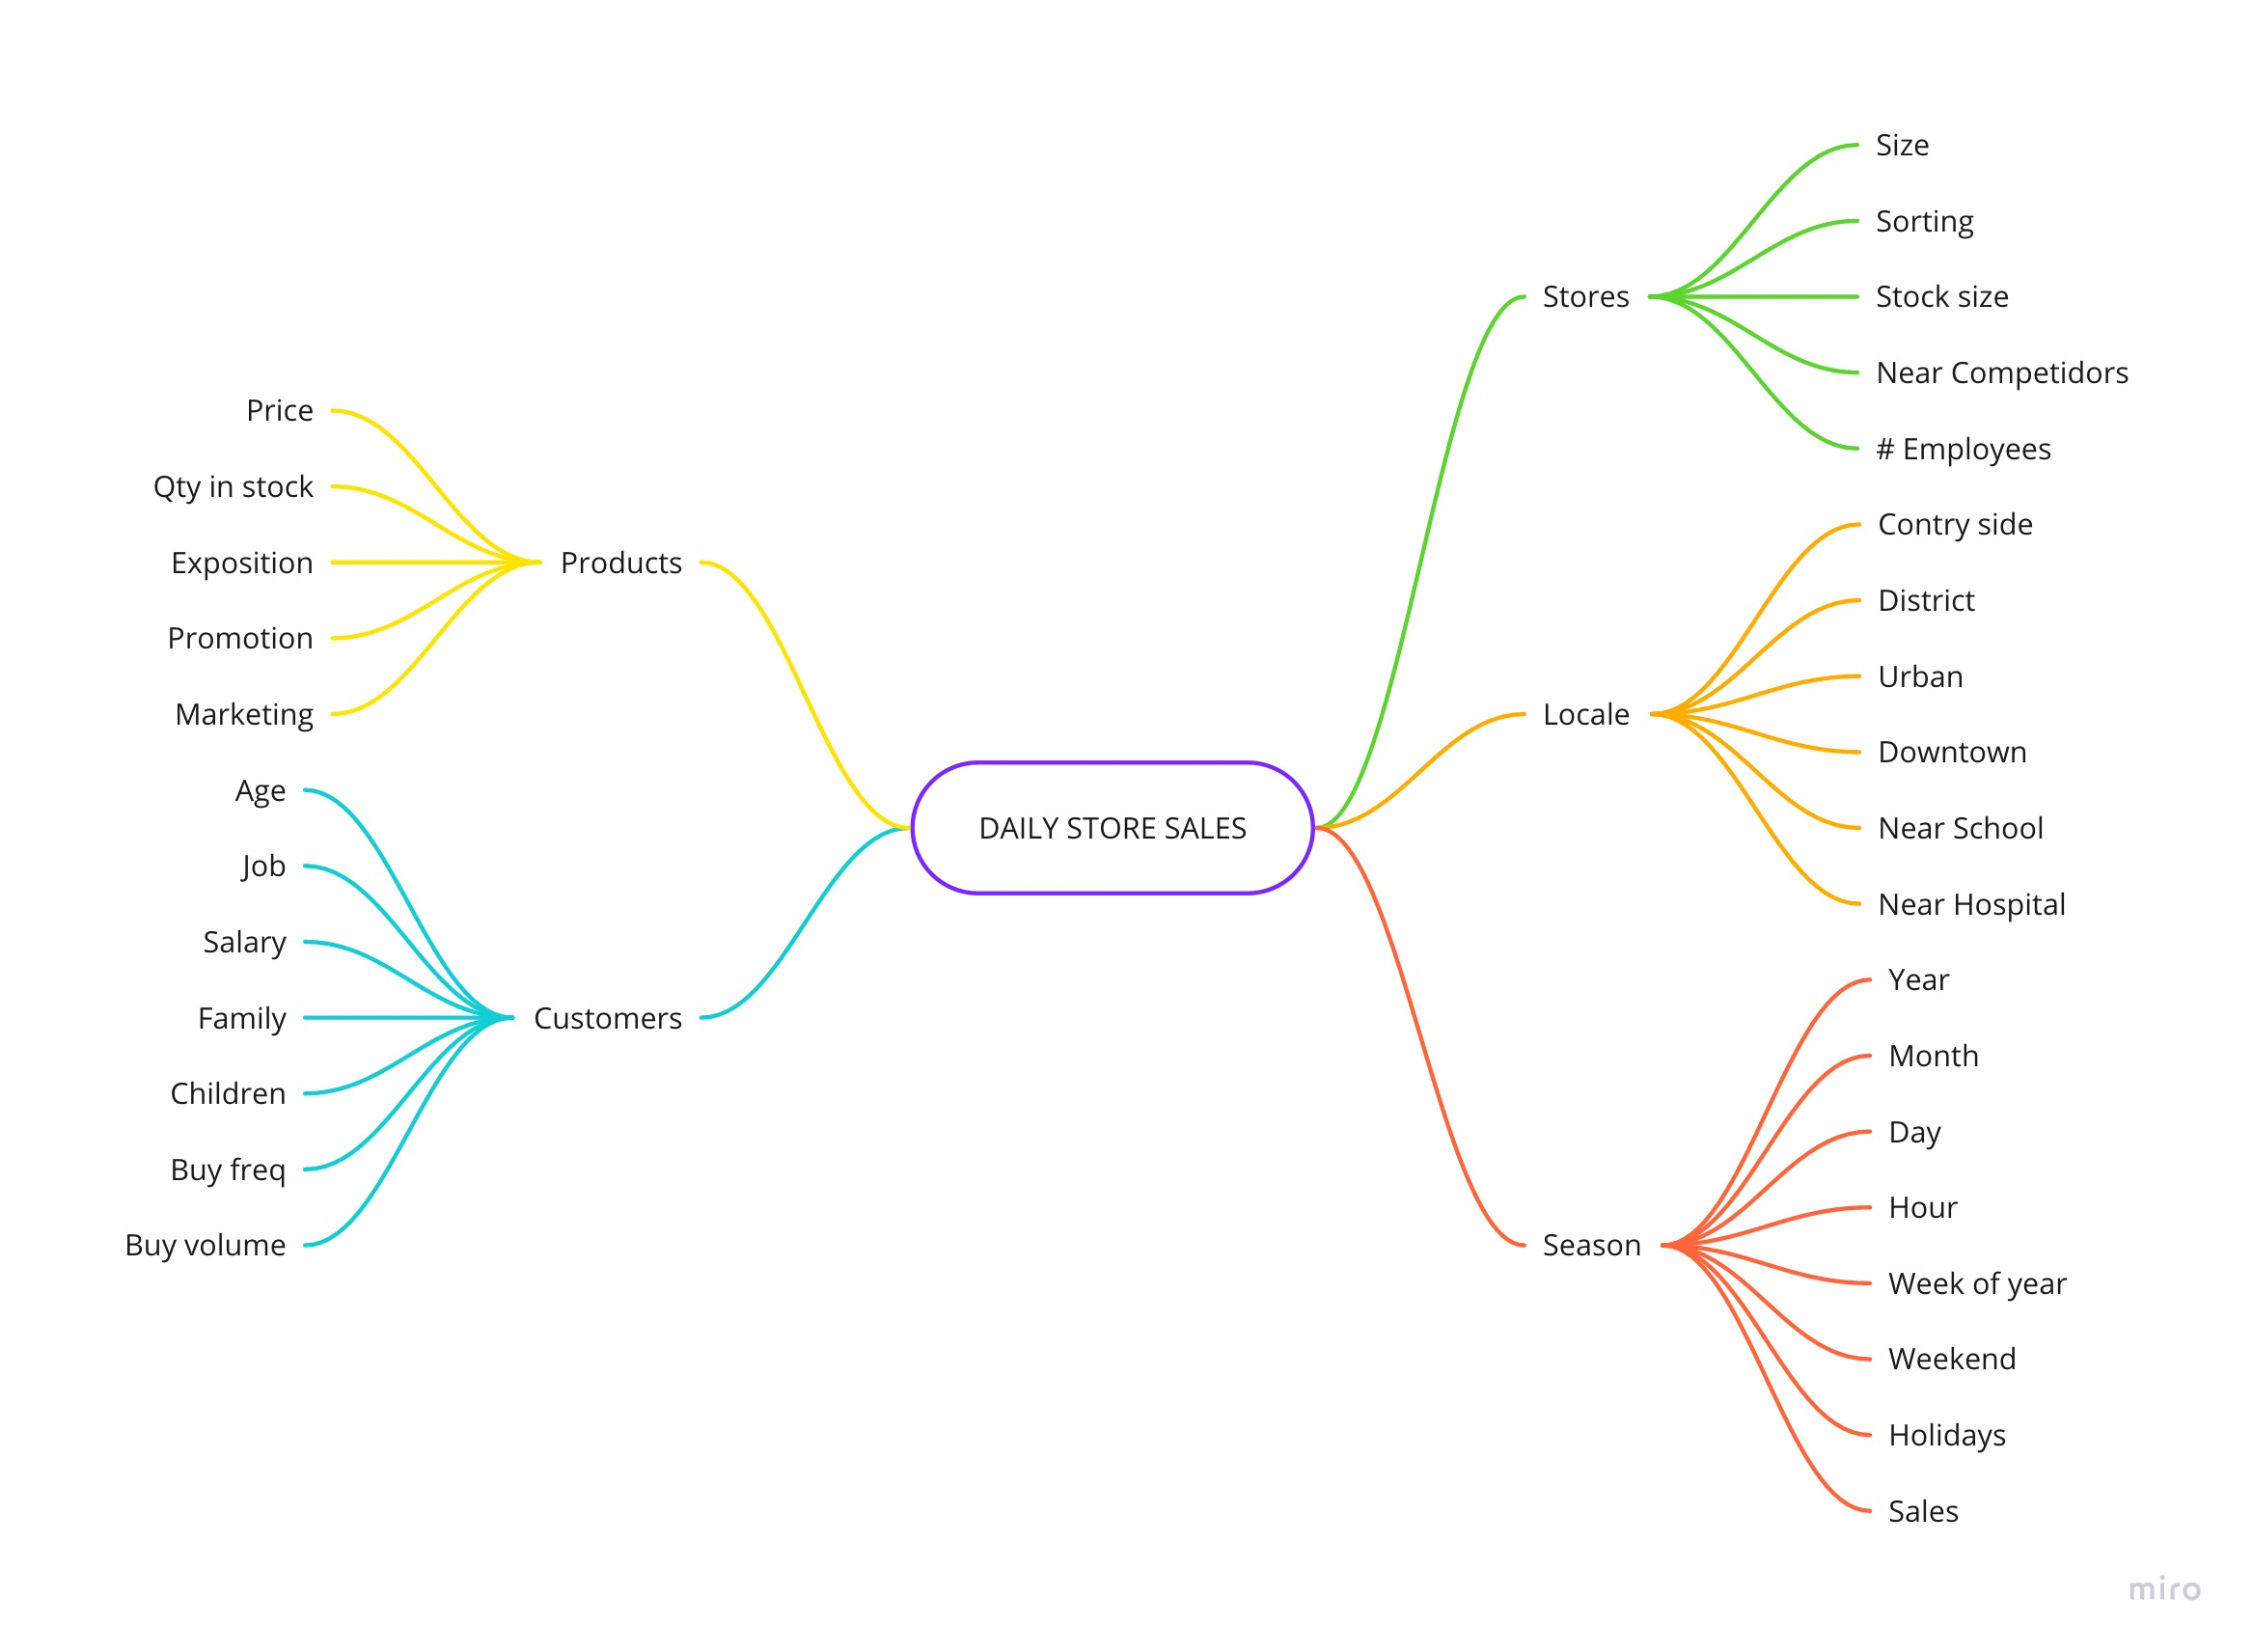

In [32]:
# displaying the mindmap
Image('img/hypothesis_map.png')

## 2.2 Creating hypothesis

Creating hypothesis for each variable that you believe that impact in the phenomenon that we are studying, in this case, **Daily Store Sales**, and relate each variable's attributes with the phenomenon.

In real life, we outline the hypothesis in a brainstorm-like meeting with the stakeholders.

### 2.2.1 Store Hypothesis

**1.** Stores with higher number of employees should have higher sales.

**2.** Stores with higher stock should should have higher sales.

**3.** Stores with higher size should should have higher sales.

**4.** Stores with lesser size should have lesser sales.

**5.** Stores with higher sorting should should have higher sales.

**6.** Stores with nearer competitors should have lesser sales.

**7.** Stores with longer competitors should have higher sales.

### 2.2.2 Product Hypothesis

**1.** Stores with higher investments in marketing should have higher sales.

**2.** Stores with higher product exposure should should have higher sales.

**3.** Stores with lesser product prices should should have higher sales.

**4.** Stores with higher discount values should should have higher sales.

**5.** Stores with lesser product prices for longer period of time should should have higher sales.

**6.** Stores with longer period of time in promotion should have higher sales.

**7.** Stores with higher consecutive promotions should have higher sales.

### 2.2.3 Season Hypothesis

**1.** Stores that open on Xmas should have higher sales. 

**2.** Stores should have higher sales along the year.

**3.** Stores should have higher sales on the second semester of the year.

**4.** Stores should have higher sales after the 10th day of the month.

**5.** Stores should have higher sales on weekends.

**6.** Stores should have higher sales during school holidays.

## 2.3 Prioritized hypothesis list
We prioritize the hypothesis based on: whether we have or not the data at hand.

There may be data that we don't have it at hand and we need to spend some time on accessing it, collecting it, cleaning it and analyzing it.

**Store**

**1.** Stores with lesser size should have lesser sales.

**2.** Stores with nearer competitors should have lesser sales.

**3.** Stores with longer competitors should have higher sales.

<br>

**Product**

**4.** Stores with lesser product prices for longer period of time should should have higher sales.

**5.** Stores with longer period of time in promotion should have higher sales.

**6.** Stores with higher consecutive promotions should have higher sales.

<br>

**Season**

**7.** Stores that open on Xmas should have higher sales. 

**8.** Stores should have higher sales along the year.

**9.** Stores should have higher sales on the second semester of the year.

**10.** Stores should have higher sales after the 10th day of the month.

**11.** Stores should have higher sales on weekends.

**12.** Stores should have higher sales during school holidays.

## 2.4 Feature engineering

In [37]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [38]:
# checking the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [41]:
# competition since

# creating a new datetime column 'competition_since' which is a compound of two columns
# we are specifying that it will always have the 1st day of the month
df2['competition_since'] = df2.apply(lambda x: 
                                     datetime.datetime(year=x['competition_open_since_year'], 
                                                                 month=x['competition_open_since_month'], 
                                                                 day=1), 
                                     axis=1)

In [42]:
# checking the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [43]:
# How many months has passed since the competition store opened?
# getting the difference between columns and divding it by 30 to make the monthly granularity
#     then we get the days as int type
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

In [44]:
# checking the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [46]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)

# converting values from 'promo_since' to datetime considering 7 days
df2['promo_since'] = df2['promo_since'].apply(lambda x: 
                         datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# How many weeks has passed since the promotion started?
# OR for how long (in weeks) the promotion is active?
# getting the difference between columns and divding it by 7 to make the weekly granularity
#     then we get the days as int type
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

In [47]:
# checking the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [51]:
# assortment
# replacing the values to make easier to understand them
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# replacing the values to make easier to understand them
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [52]:
# checking the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
